In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

Welcome to JupyROOT 6.12/04


In [2]:
# Blind trolley and fixed probe separately, but blind all fixed probe stations the same
# Blind dipole by order 1 ppm = 61.79 Hz
# Blind higher moments by order 100 ppb = 6.179 Hz
tr_blinds = np.zeros(17)
# tr_blinds[0] = np.random.uniform(-61.79, 61.79)
# tr_blinds[1:] = np.random.uniform(-6.179, 6.179, 16)
fp_blinds = np.zeros(6)
# fp_blinds[0] = np.random.uniform(-61.79, 61.79)
# fp_blinds[1:] = np.random.uniform(-6.179, 6.179, 5)

def blind_tr_moment_df(moment_df, fp_blinds, tr_blinds):
    out_df = moment_df.copy()
    out_df['tr,m1'] = moment_df['tr,m1'] + tr_blinds[0]
    for st in np.arange(72):
        stm = 'st' + str(st) + ',m1'
        out_df[stm] = moment_df[stm] + fp_blinds[0]
    for m in np.arange(2,7):
        trm = 'tr,m' + str(m)
        out_df[trm] = moment_df[trm] + tr_blinds[m-1]
        for st in np.arange(72):
            stm = 'st' + str(st) + ',m' + str(m)
            out_df[stm] = moment_df[stm] + fp_blinds[m-1]

    # Blind higher order trolley moments by order 100 ppb = 6.179 Hz
    for m in np.arange(7,18):
        trm = 'tr,m' + str(m)
        out_df[trm] = moment_df[trm] + tr_blinds[m-1]
        
    return out_df

def blind_fp_moment_df(moment_df, fp_blinds):
    # Blind trolley and fixed probe separately, but blind all fixed probe stations the same
    # Blind dipole by order 1 ppm = 61.79 Hz
    out_df = moment_df.copy()
    for st in np.arange(72):
        stm = 'st' + str(st) + ',m1'
        out_df[stm] = moment_df[stm] + fp_blinds[0]
    
    # Blind quads, sexts, m6 by order 100 ppb = 6.179 Hz
    for m in np.arange(2,7):
        for st in np.arange(72):
            stm = 'st' + str(st) + ',m' + str(m)
            out_df[stm] = moment_df[stm] + fp_blinds[m-1]
        
    return out_df

station_phi = trfp.STATION_BARCODE_PHI
station_edges = trfp.STATION_BARCODE_EDGES

# corrected_df_1 = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_corrected_df')
corrected_df_1 = trfp.remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df'))
# corrected_df_1 = blind_tr_moment_df(corrected_df_1, fp_blinds, tr_blinds)
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, _ = trfp.trolley_run_station_average(corrected_df_1)

# corrected_df_2 = pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_corrected_df')
corrected_df_2 = trfp.remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df'))
# corrected_df_2 = blind_tr_moment_df(corrected_df_2, fp_blinds, tr_blinds)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, _ = trfp.trolley_run_station_average(corrected_df_2)

# load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
print 'Appending fixed probe runs.'
fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
pts = fp_moment_df.shape[0]
for run in np.arange(3959, 3995):
    temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    fp_moment_df = fp_moment_df.append(temp_df)
    
print '\nBlinding fixed probe runs.'
# fp_moment_df = blind_fp_moment_df(fp_moment_df, fp_blinds)

# load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
print '\nAppending trolley runs.'
tr_corrected_df = trfp.remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_moment_df'))
for run in np.arange(3956, 3959):
    temp_df = trfp.remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)
for run in np.arange(3995, 3999):
    temp_df = trfp.remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)

print '\nBlinding trolley runs.'
# tr_corrected_df = blind_tr_moment_df(tr_corrected_df, fp_blinds, tr_blinds)

print '\nDone appending runs.'

### Apply baseline corrections, generate virtual trolley measurements

fp_moment_baseline = fp_moment_df.copy()
fp_moment_tr_run_baseline = tr_corrected_df.copy()

# apply baseline corrections to each fp stm
print "\nSubtracting fixed probe baselines."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction(time):
            c1 = fp_baseline_1[st, m]
            c2 = fp_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1
        
        correction = backwards_correction(fp_moment_baseline.index.values)
        fp_moment_baseline[stm] = fp_moment_baseline[stm] - correction
        correction = backwards_correction(fp_moment_tr_run_baseline.index.values)
        fp_moment_tr_run_baseline[stm] = fp_moment_tr_run_baseline[stm] - correction
        
        print '\rstm: ' + stm + '.',
        
# replace columns in vtr with Jacobian-fixed columns from fp baseline correction

print "\n\nApplying Jacobian."
vtr_df = fp_moment_df.copy()
vtr_tr_run_df = tr_corrected_df.copy()

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41:
            J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39:
            J = trfp.J_4_PROBE_ST37_ST39
        else:
            J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
    # run over each vtr moment:
    for m in np.arange(num_moments):
        vtr_stm = 'st'+str(st)+',m'+str(m+1)
        fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
        vtr_df[vtr_stm] = fp_moment_baseline[fp_stm].dot(J[m])
        vtr_tr_run_df[vtr_stm] = fp_moment_tr_run_baseline[fp_stm].dot(J[m])
        
        print '\rstm: ' + stm + '.',
        
# Add trolley baseline correction (with backwards correction)
print "\n\nAdding trolley baselines."

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)
        
        def backwards_correction(time):
            c1 = tr_baseline_1[st, m]
            c2 = tr_baseline_2[st, m]
            t1 = baseline_time_1[st]
            t2 = baseline_time_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1
        
        correction = backwards_correction(vtr_df.index.values)
        vtr_df[stm] = vtr_df[stm] + correction
        correction = backwards_correction(vtr_tr_run_df.index.values)
        vtr_tr_run_df[stm] = vtr_tr_run_df[stm] + correction
        
        print '\rstm: ' + stm + '.',

print '\n\nDone.'

Finished removing trolley images from 4382 events.                        
Finished removing trolley images from 4359 events.                         
Appending fixed probe runs.
Appending run 3994.                                    
Blinding fixed probe runs.

Appending trolley runs.
Finished removing trolley images from 893 events.        
Finished removing trolley images from 4382 events.                        
Finished removing trolley images from 2977 events.             
Finished removing trolley images from 539 events.        
Finished removing trolley images from 365 events.        
Finished removing trolley images from 921 events.       
Finished removing trolley images from 4359 events.                         
Finished removing trolley images from 2853 events.             
Appending run 3998. 
Blinding trolley runs.

Done appending runs.

Subtracting fixed probe baselines.
stm: st71,m4.      

Applying Jacobian.
stm: st71,m4.              

Adding trolley baselines.
stm: s

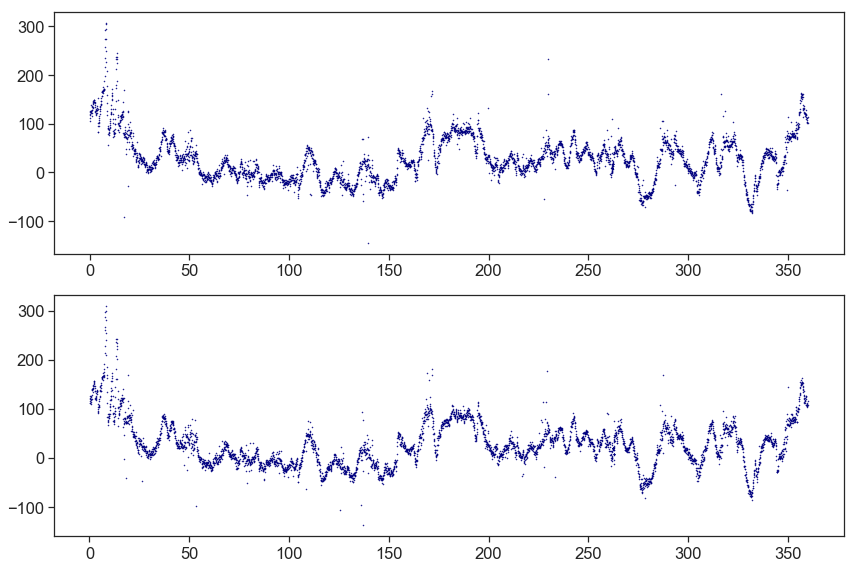

In [96]:
tr_run_1 = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df')
tr_run_2 = pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df')

tr_moment = 'tr,m17'

fig, ax = plt.subplots(2,1)
plt.sca(ax[0])
plt.plot(tr_run_1['tr_phi'], tr_run_1[tr_moment], '.', markersize=1, color='navy')
plt.sca(ax[1])
plt.plot(tr_run_2['tr_phi'], tr_run_2[tr_moment], '.', markersize=1, color='navy')

fig.set_size_inches(12,8)
fig.tight_layout()

In [43]:
tr_run_1_azi = tr_run_1.copy()
tr_run_1_azi = tr_run_1_azi.set_index('tr_phi')[['tr,m'+str(N+1) for N in range(17)]].round(3).sort_index()

tr_run_1_azi.to_csv('tr_run_3956.dat', sep=' ', index_label='azimuth', float_format='%0.4f')

tr_run_2_azi = tr_run_2.copy()
tr_run_2_azi = tr_run_2_azi.set_index('tr_phi')[['tr,m'+str(N+1) for N in range(17)]].round(3).sort_index()

tr_run_2_azi.to_csv('tr_run_3997.dat', sep=' ', index_label='azimuth', float_format='%0.4f')

In [30]:
# The un-drift corrected trolley average

for x in np.round(np.matmul(np.transpose(tr_baseline_1),summed_azimuth_1)/360, 4):
    print x

print '\n'
    
for x in np.round(np.matmul(np.transpose(tr_baseline_2),summed_azimuth_2)/360, 4):
    print x


52010.3692
-0.6872
9.8923
17.2108
-72.9153
-0.1393
17.2563
-25.7472
-75.2155
130.8972
181.0174
-69.1123
0.0
-297.7444
319.6603
80.5156
27.5251


51954.6388
16.6207
23.529
22.4189
-78.5461
0.3433
18.0661
-38.3901
-74.5313
97.5617
167.6257
-69.3352
0.0
-241.1199
298.4277
117.5999
27.2748


In [47]:
vtr_df.index.values[-1]

1524640835.0

In [48]:
# bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500
bin_centers = np.arange(1524384055, 1524640055, 1000)

# bins = np.arange(1524383560, 1524640850, 10)-5
# bin_centers = np.arange(1524383560, 1524640840, 10)

vtr_time_bin_df = vtr_df.groupby(pd.cut(vtr_df.index,bins)).mean()
vtr_time_bin_df.index = bin_centers
vtr_time_bin_df.head()


# print vtr_time_bin_df.iloc[[0,-1]]
# print vtr_time_bin_df.shape
# print bin_centers.shape

,"st0,m1","st0,m2","st0,m3","st0,m4","st0,m5","st0,m6","st1,m1","st1,m2","st1,m3","st1,m4",...,"st70,m3","st70,m4","st70,m5","st70,m6","st71,m1","st71,m2","st71,m3","st71,m4","st71,m5","st71,m6"
1524384055,51448.575398,98.226854,-89.663375,-41.550512,17.420886,-843.862933,50363.674030,47.114288,47.099335,355.950370,...,-25.706629,-39.356128,-78.000023,551.119009,51421.277339,55.609394,-36.453088,53.551460,NaN,NaN
1524385055,51448.064851,98.530441,-89.608410,-41.531842,17.222177,-843.978433,50377.573766,59.972438,50.110497,356.660642,...,-25.673061,-39.335765,-77.973357,551.249428,51420.541543,55.822065,-36.456569,53.581169,NaN,NaN
1524386055,51445.798533,98.731518,-89.557940,-41.541357,17.170641,-844.277597,50384.796592,62.854016,50.404339,355.785148,...,-25.655062,-39.365224,-78.330994,550.992544,51416.970289,56.084082,-36.425688,53.534626,NaN,NaN
1524387055,51445.125769,98.920827,-89.536705,-41.528831,17.126977,-844.223780,50361.391073,52.660424,48.254124,355.709694,...,-25.715881,-39.337073,-77.989918,551.070579,51413.122706,56.367498,-36.500172,53.579603,NaN,NaN
1524388055,51443.917896,99.343106,-89.469818,-41.527537,17.140898,-844.332414,50362.162781,51.182113,46.865154,355.014687,...,-25.738931,-39.289471,-78.136445,551.282862,51408.788152,57.031983,-36.491896,53.566521,NaN,NaN


In [49]:
test_df = vtr_time_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

weight = summed_azimuth_1+summed_azimuth_2
total_weight = np.sum(summed_azimuth_1 + summed_azimuth_2)

for m in np.arange(6):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight

In [50]:
review_df = azi_avg_df[['m1', 'm2', 'm3', 'm5']].copy()

review_df['m1_unc'] = 0.116
review_df['m2_unc'] = 0.060
review_df['m3_unc'] = 0.062
review_df['m5_unc'] = 0.100

review_df['m1'] = review_df['m1']/61.79
review_df['m2'] = review_df['m2']/61.79
review_df['m3'] = review_df['m3']/61.79
review_df['m5'] = review_df['m5']/61.79

review_df = review_df.reindex(sorted(review_df.columns), axis=1)

print review_df.head()

                    m1  m1_unc        m2  m2_unc        m3  m3_unc        m5  \
1524384055  841.784507   0.116  0.069976    0.06  0.164227   0.062 -0.883436   
1524385055  841.785792   0.116  0.080025    0.06  0.164765   0.062 -0.882973   
1524386055  841.785998   0.116  0.083589    0.06  0.165902   0.062 -0.882062   
1524387055  841.777327   0.116  0.082084    0.06  0.165798   0.062 -0.888290   
1524388055  841.784418   0.116  0.087722    0.06  0.166186   0.062 -0.885766   

            m5_unc  
1524384055     0.1  
1524385055     0.1  
1524386055     0.1  
1524387055     0.1  
1524388055     0.1  


In [51]:
review_df.to_csv('purcell_60hr_unblinded_1000sec_bins.dat', sep=' ', index_label='time', float_format='%0.4f')

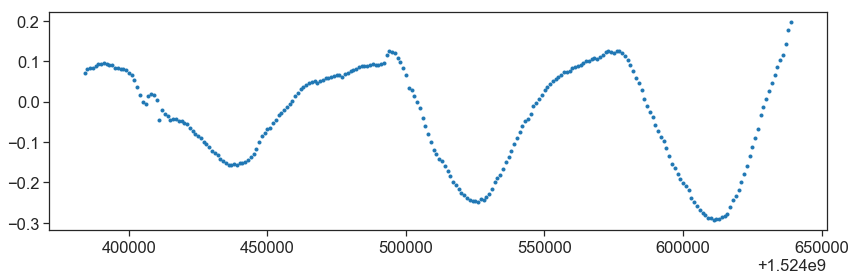

In [54]:
plt.plot(review_df.index.values, review_df['m2'], '.')
fig = plt.gcf()
fig.set_size_inches(12,4)
fig.tight_layout()

In [59]:
PLUNGING_PROBE_CALIBRATIONS = [-31.806,  # 0
                               -37.326,  # 1
                               -27.731,  # 2
                               -34.009,  # 3
                               -29.533,  # 4
                               -13.879,  # 5
                               -3.943,  # 6
                               -42.120,  # 7
                               -40.291,  # 8
                               -99.849,  # 9
                               54.585,  # 10
                               -8.270,  # 12
                               3.029,  # 13
                               -40.572,  # 14
                               -44.231,  # 15
                               -100.948,  # 16
                               50.725]  # 17

for i in np.matmul(trfp.THETA_TR, PLUNGING_PROBE_CALIBRATIONS):
    print np.round(i,3)

-24.428
0.428
3.496
-2.835
-66.975
2.498
-1.049
-359.574
-78.03
87.575
36.058
122.844
0.0
-142.083
61.975
961.265
28.555


In [62]:
PLUNGING_PROBE_CALIBRATIONS = [-31.574,
                               -37.545,
                               -27.665,
                               -33.719,
                               -29.534,
                               -13.933,
                               -4.149,
                               -42.405,
                               -40.163,
                               -100.103,
                               54.498,
                               -9.157,
                               2.88,
                               -40.099,
                               -43.37,
                               -100.348,
                               51.747]

for i in np.matmul(trfp.THETA_TR, PLUNGING_PROBE_CALIBRATIONS):
    print np.round(i/61.79,6)

-0.393611
-0.002486
0.050359
-0.040286
-1.075765
0.04291
-0.012755
-5.87432
-1.269195
2.024719
1.600421
2.000095
0.0
-3.302294
2.683476
15.697073
0.464462


In [68]:
print trfp.THETA_TR[0,:]

[ 7.69230769e-02 -9.57290471e-15 -1.90704325e-16  1.02356300e-14
  1.41610202e-15  7.69230769e-02  7.69230769e-02  7.69230769e-02
  7.69230769e-02  7.69230769e-02  7.69230769e-02  7.69230769e-02
  7.69230769e-02  7.69230769e-02  7.69230769e-02  7.69230769e-02
  7.69230769e-02]
